<a href="https://colab.research.google.com/github/Zhang-Siyuan-Ella/dssi-py/blob/main/Workshop_DNN_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gather Data using APIs

In [ ]:
# data
# we will try to pull data for AMZN share price
# then we will try to predict the stock prices using vanilla RNN

In [ ]:
!pip install yfinance # uncomment it to download

In [ ]:
# required libraries
import pandas as pd
import numpy as np
import datetime as dt

# for plots
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
# ticker of choice
tick = ['AAPL'] # you can add more or add ticker of choice such as IBM, AAPL, GOOG, GM etc.

# let us start with 2015
begin_period = '2020-01-01'
end_period = '2021-01-01'

In [ ]:
import yfinance as yf
# documentation: https://github.com/ranaroussi/yfinance

In [ ]:
data = yf.download(tick, start=begin_period, end=end_period)
data.head(4)

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.796028,72.856621,71.545395,71.799881,135480400
2020-01-03,72.088303,72.851769,71.862900,72.020439,146322800
2020-01-06,72.662712,72.701492,70.954002,71.206070,118387200
2020-01-07,72.320992,72.929337,72.100433,72.672425,108872000


In [ ]:
data.tail(4)

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-12-28,133.663010,134.298609,130.553423,131.022804,124486200
2020-12-29,131.883286,135.716475,131.365024,134.992872,121047300
2020-12-30,130.758789,132.978524,130.445868,132.577600,96452100
2020-12-31,129.751572,131.756177,128.803051,131.110789,99116600


## including all weekdays in the data

In [ ]:
# quantitative trading strategies often require all weekdays
# df = data.Close
# # let us get all the weekdays in the desired date range
# weekdays = pd.date_range(start= begin_period, end = end_period, freq='B')

# df = df.reindex(weekdays)
# df.head()

In [ ]:
# df = pd.DataFrame(df.fillna(method='bfill'))
# df = df.fillna(0)
# df.head()

In [ ]:
df = pd.DataFrame(data)
# get rownames as columns 设置 DataFrame 中行索引的名
df.index.name = 'Date'
#这将把之前的索引列（在本例中为 'Date'）转移到普通的列，并将 DataFrame 的索引恢复为默认的 0, 1, 2, … 等整数索引
df.reset_index(inplace=True)

In [ ]:
df.head(4)

Price,Date,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL
0,2020-01-02,72.796028,72.856621,71.545395,71.799881,135480400
1,2020-01-03,72.088303,72.851769,71.862900,72.020439,146322800
2,2020-01-06,72.662712,72.701492,70.954002,71.206070,118387200
3,2020-01-07,72.320992,72.929337,72.100433,72.672425,108872000


In [ ]:
print(df.columns)
print(df.dtypes)
print(df.describe)

MultiIndex([(  'Date',     ''),
            ( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])
Price   Ticker
Date              datetime64[ns]
Close   AAPL             float64
High    AAPL             float64
Low     AAPL             float64
Open    AAPL             float64
Volume  AAPL               int64
dtype: object
<bound method NDFrame.describe of Price        Date       Close        High         Low        Open     Volume
Ticker                   AAPL        AAPL        AAPL        AAPL       AAPL
0      2020-01-02   72.796028   72.856621   71.545395   71.799881  135480400
1      2020-01-03   72.088303   72.851769   71.862900   72.020439  146322800
2      2020-01-06   72.662712   72.701492   70.954002   71.206070  118387200
3      2020-01-07   72.320992   72.929337   72.100433   72.672425  108872000
4      2020-01-08   73.484352   73.787315   72

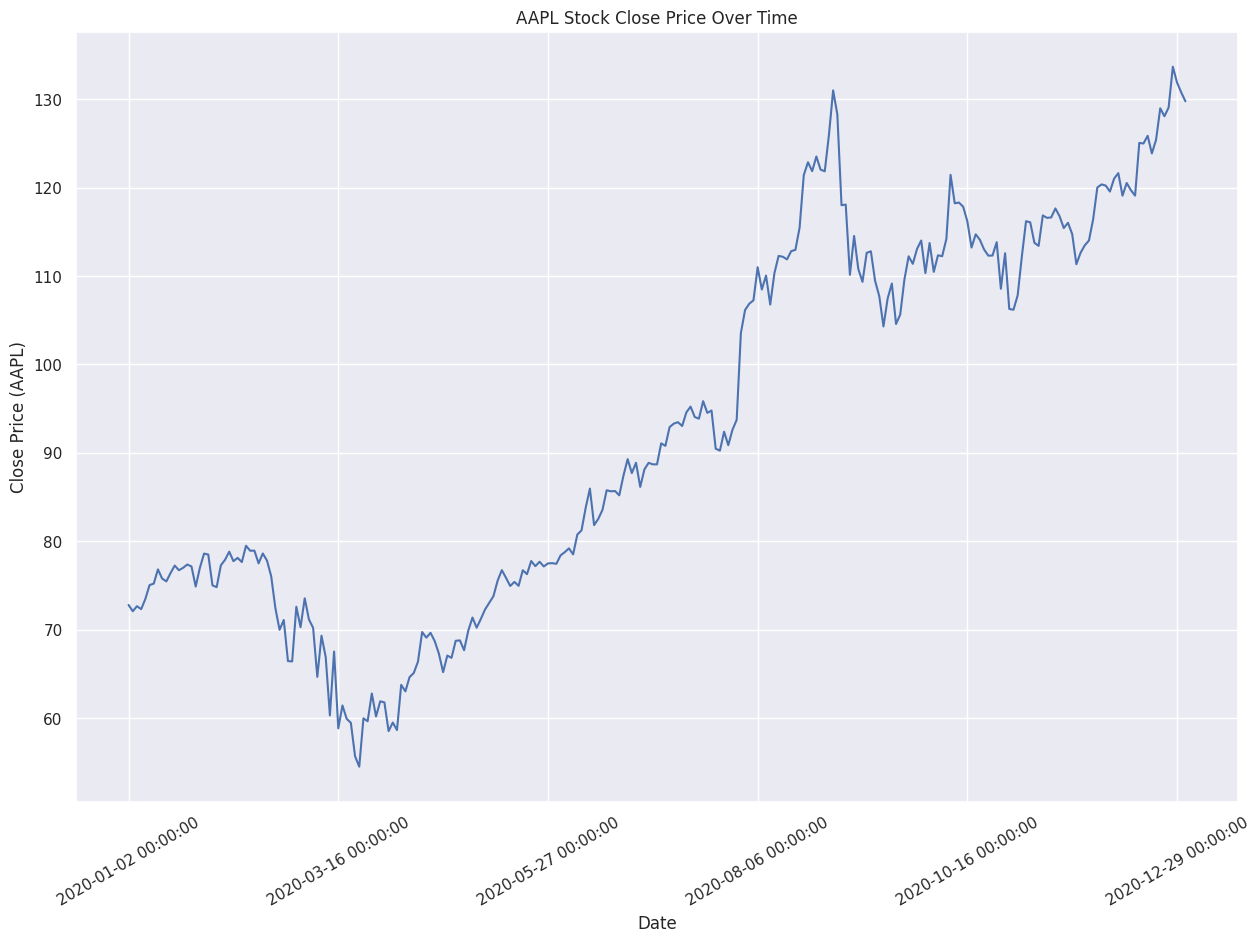

In [ ]:
# let us plot this data
# to do:pls complete the figure with adding lables to axes
sns.set_theme()
plt.figure(figsize= (15, 10))
plt.plot(df.Close)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Close Price (AAPL)')
plt.title('AAPL Stock Close Price Over Time')
#plt.xticks(range(0, df.shape[0], 100), df.Date.loc[::50], rotation=30)
# plt.plot(roll_mean, color='red')
# Optional: If you want to rotate x-axis labels for better readability
plt.xticks(range(0, df.shape[0], 50), df['Date'].loc[::50], rotation=30)

plt.show()

# Data Prep

In [ ]:
# min max standardization
scale = MinMaxScaler(feature_range=(-1, 1))
# scale.fit_transform(df.Close.values) # gives error that 2D expected and got 1D
df['Close_norm'] = scale.fit_transform(df.Close.values.reshape(-1, 1))
df['Open_norm'] = scale.fit_transform(df.Open.values.reshape(-1, 1))
df['High_norm'] = scale.fit_transform(df.High.values.reshape(-1, 1))
df['Low_norm'] = scale.fit_transform(df.Low.values.reshape(-1, 1))

In [ ]:
def train_test_prep(series, x_variables, y_variables,  window_size, test_prop=0.2, validation_prop = 0.1):
  # series should be a numpy seriesx_data 和 y_data 最终会被转换成 numpy 数组，这样可以方便后续的训练集、验证集、测试集的划分。
  x_series = series[x_variables].to_numpy()
  y_series = series[y_variables].to_numpy()
  x_data = []
  y_data = []
  for i in range(len(x_series) - window_size):
    x_data.append(x_series[i: i+window_size])
    y_data.append(y_series[i+window_size])
  x_data = np.array(x_data)
  y_data = np.array(y_data)
  print(x_data[1])
  print(y_data[1])




  test_size = int(np.round(test_prop* x_data.shape[0]))
  validation_size = int(np.round(validation_prop* x_data.shape[0]))
  train_size = x_data.shape[0] - test_size - validation_size

  train_x = x_data[:train_size, :-1,:]
  train_y = y_data[:train_size, :]

  print("X:", train_x.shape)
  print("Y:", train_y.shape)

  validation_x = x_data[train_size:train_size+validation_size,:-1,:]
  validation_y = y_data[train_size:train_size+validation_size,:]

  test_x = x_data[train_size+validation_size:train_size+validation_size+test_size, :-1,:]
  test_y = y_data[train_size+validation_size:train_size+validation_size+test_size:, :]

  return [train_x, train_y, validation_x, validation_y, test_x, test_y]

In [ ]:
ws = 12

x_train, y_train, x_validation, y_validation, x_test, y_test = train_test_prep(df, ["Close_norm","Open_norm"], ["Close_norm"], ws)

print('train_x', x_train.shape)#train_x (2106, 11, 1)
print('train_y', y_train.shape)#train_y (2106, 1)

print('validation_x', x_validation.shape)#validation_x (2106, 11, 1)
print('validation_y', y_validation.shape)#validation_y (2106, 1)

print('test_x', x_test.shape)#test_x (902, 11, 1)
print('test_y', y_test.shape)#test_y (902, 1, 1)

[[-0.55583511 -0.58258403]
 [-0.54132126 -0.60305026]
 [-0.54995566 -0.56619874]
 [-0.52056052 -0.58252326]
 [-0.48112178 -0.52112535]
 [-0.47683485 -0.50065895]
 [-0.43623195 -0.49432396]
 [-0.46244302 -0.46350296]
 [-0.47064908 -0.49304468]
 [-0.44676576 -0.48244679]
 [-0.42539258 -0.46612266]
 [-0.43862062 -0.46051876]]
[-0.4316998]
X: (169, 11, 2)
Y: (169, 1)
train_x (169, 11, 2)
train_y (169, 1)
validation_x (24, 11, 2)
validation_y (24, 1)
test_x (48, 11, 2)
test_y (48, 1)


In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]*x_train.shape[2]))
x_validation =  np.reshape(x_validation, (x_validation.shape[0], x_validation.shape[1]*x_validation.shape[2]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]*x_test.shape[2]))

In [ ]:
print('train_x', x_train.shape)#train_x (2106, 11, 1)
print('train_y', y_train.shape)#train_y (2106, 1)

print('validation_x', x_validation.shape)#validation_x (2106, 11, 1)
print('validation_y', y_validation.shape)#validation_y (2106, 1)

print('test_x', x_test.shape)#test_x (902, 11, 1)
print('test_y', y_test.shape)#test_y (902, 1, 1)

train_x (169, 22)
train_y (169, 1)
validation_x (24, 22)
validation_y (24, 1)
test_x (48, 22)
test_y (48, 1)


In [ ]:
type(x_train)

numpy.ndarray

In [ ]:
y_train.shape[0]
y_validation.shape[0]

24

In [ ]:
# base line model
from sklearn.metrics import mean_squared_error

#y_base_pred = np.array(df["Close"][ws-1:ws-1+y_train.shape[0]],dtype=np.float32)
#mse_loss_train = mean_squared_error(y_base_pred, np.squeeze(y_train))

y_base_test = np.array(df["Close"][ws+y_train.shape[0]+y_validation.shape[0]-1:-1],dtype=np.float32)
y_base_label = np.array(df["Close"][ws+y_train.shape[0]+y_validation.shape[0]:],dtype=np.float32)

print(y_base_test, y_base_label)
rmse_loss_test = np.sqrt(mean_squared_error(y_base_test, y_base_label))

print(rmse_loss_test)

[[112.991776]
 [112.298706]
 [112.30846 ]
 [113.82152 ]
 [108.55021 ]
 [112.572014]
 [106.26597 ]
 [106.17811 ]
 [107.80832 ]
 [112.21082 ]
 [116.19362 ]
 [116.0616  ]
 [113.7441  ]
 [113.40185 ]
 [116.843895]
 [116.57009 ]
 [116.618996]
 [117.63596 ]
 [116.74609 ]
 [115.416214]
 [116.01271 ]
 [114.7415  ]
 [111.3288  ]
 [112.619545]
 [113.46052 ]
 [114.00811 ]
 [116.41364 ]
 [120.002365]
 [120.354385]
 [120.2175  ]
 [119.54278 ]
 [121.00956 ]
 [121.6256  ]
 [119.083176]
 [120.51084 ]
 [119.699234]
 [119.083176]
 [125.0481  ]
 [124.979645]
 [125.84994 ]
 [123.85512 ]
 [125.39034 ]
 [128.95952 ]
 [128.05988 ]
 [129.04752 ]
 [133.66301 ]
 [131.88329 ]
 [130.75879 ]] [[112.298706]
 [112.30846 ]
 [113.82152 ]
 [108.55021 ]
 [112.572014]
 [106.26597 ]
 [106.17811 ]
 [107.80832 ]
 [112.21082 ]
 [116.19362 ]
 [116.0616  ]
 [113.7441  ]
 [113.40185 ]
 [116.843895]
 [116.57009 ]
 [116.618996]
 [117.63596 ]
 [116.74609 ]
 [115.416214]
 [116.01271 ]
 [114.7415  ]
 [111.3288  ]
 [112.619545]
 [113

In [ ]:
#  put all arrays to tensors
x_train = torch.from_numpy(x_train).type(torch.Tensor).cuda()
x_test = torch.from_numpy(x_test).type(torch.Tensor).cuda()
x_validation = torch.from_numpy(x_validation).type(torch.Tensor).cuda()
y_train = torch.from_numpy(y_train).type(torch.Tensor).cuda()
y_test = torch.from_numpy(y_test).type(torch.Tensor).cuda()
y_validation = torch.from_numpy(y_validation).type(torch.Tensor).cuda()


In [ ]:
print('train_x', x_train.shape)#train_x (2106, 11, 1)
print('train_y', y_train.shape)#train_y (2106, 1)

print('test_x', x_test.shape)#test_x (902, 11, 1)
print('test_y', y_test.shape)#test_y (902, 1, 1)

print('validation_x', x_validation.shape)#test_x (902, 11, 1)
print('validation_y', y_validation.shape)#test_y (902, 1, 1)

train_x torch.Size([169, 22])
train_y torch.Size([169, 1])
test_x torch.Size([48, 22])
test_y torch.Size([48, 1])
validation_x torch.Size([24, 22])
validation_y torch.Size([24, 1])


In [ ]:
print(x_train[20])

tensor([-0.4819, -0.4377, -0.4871, -0.5390, -0.4247, -0.4720, -0.4087, -0.4220,
        -0.3857, -0.4277, -0.4128, -0.4243, -0.4034, -0.4743, -0.4154, -0.4168,
        -0.3688, -0.4298, -0.3831, -0.4132, -0.3826, -0.4098], device='cuda:0')


In [ ]:
print(y_train[20])

tensor([-0.3907], device='cuda:0')


## Deep Neural Network

In [ ]:
# write the model class
# we opt for 2 hidden layers
class DNN(nn.Module):
  def __init__(self, input_neurons, h1, h2,h3, output_neurons):
    super(DNN, self).__init__()# inheriting super class
    self.fc1 = nn.Linear(input_neurons, h1) # initial layer from main features (4 independent variables of data)
    self.fc2 = nn.Linear(h1, h2) # first hidden layer
    self.fc3 = nn.Linear(h2, h3) # output
    self.fc4 = nn.Linear(h3, output_neurons) # output
    self.relu = nn.ReLU() # other activation to use nn.Tanh, nn.ReLu
    self.dropout = nn.Dropout(p = 0.25)

    # let's write the feed forward logic
  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.relu(self.fc3(x))
    out = self.fc4(x)
    # y = self.fc1(x)
    # y = self.relu(y)
    # # y = self.droput(y)
    # y = self.fc2(y)
    # y = self.tanh(y)
    # # y = self.droput(y)
    # out = self.fc3(y)
    return out

In [ ]:
# optimize
input_Size, output_Size = x_train.shape[1], 1
h1 = 16
h2 = 12
h3 = 8
# model instantiation
model = DNN(input_Size, h1,h2,h3, output_Size).cuda()

num_epochs = 400

In [ ]:
cr = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
import time

train_hist = np.zeros(num_epochs)
validation_hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []


for t in range(num_epochs):
  model.train()
  y_train_pred = model(x_train)
  loss = cr(y_train_pred, y_train)
  train_hist[t] = loss.item()

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  with torch.no_grad():
    y_validation_pred = model(x_validation)
    loss = cr(y_validation_pred, y_validation)
    validation_hist[t] = loss.item()
    print("Epoch ", t, "train MSE: ", train_hist[t], "validation MSE:", validation_hist[t])

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 train MSE:  0.3910800516605377 validation MSE: 0.09611636400222778
Epoch  1 train MSE:  0.3489294946193695 validation MSE: 0.10037057101726532
Epoch  2 train MSE:  0.30592119693756104 validation MSE: 0.09896409511566162
Epoch  3 train MSE:  0.2708039879798889 validation MSE: 0.09041579812765121
Epoch  4 train MSE:  0.2274925708770752 validation MSE: 0.07504556328058243
Epoch  5 train MSE:  0.1812065839767456 validation MSE: 0.052181776612997055
Epoch  6 train MSE:  0.1413864642381668 validation MSE: 0.030675265938043594
Epoch  7 train MSE:  0.09455540776252747 validation MSE: 0.017272204160690308
Epoch  8 train MSE:  0.05105975642800331 validation MSE: 0.011244956403970718
Epoch  9 train MSE:  0.06055780127644539 validation MSE: 0.013262126594781876
Epoch  10 train MSE:  0.07944332808256149 validation MSE: 0.016014669090509415
Epoch  11 train MSE:  0.08080476522445679 validation MSE: 0.01634986326098442
Epoch  12 train MSE:  0.10164383053779602 validation MSE: 0.01355794444680

In [ ]:
predict = pd.DataFrame(scale.inverse_transform(y_train_pred.cpu().detach().numpy()))
original = pd.DataFrame(scale.inverse_transform(y_train.cpu().detach().numpy()))

[Text(-25.0, 0, ''),
 Text(0.0, 0, ''),
 Text(25.0, 0, ''),
 Text(50.0, 0, ''),
 Text(75.0, 0, ''),
 Text(100.0, 0, ''),
 Text(125.0, 0, ''),
 Text(150.0, 0, ''),
 Text(175.0, 0, ''),
 Text(200.0, 0, '')]

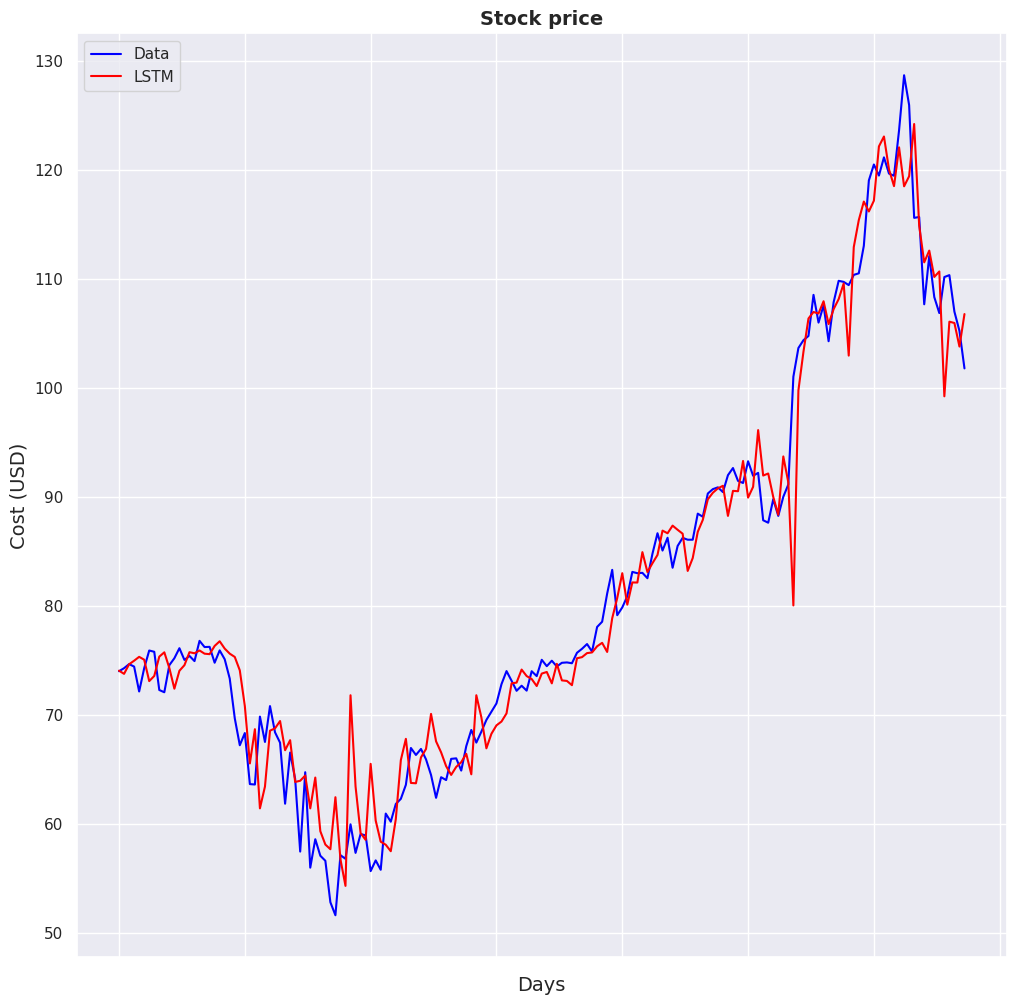

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.2, wspace=0.2)


ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='blue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="LSTM", color='red')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


#plt.subplot(1, 2, 2)
#ax = sns.lineplot(data=hist, color='royalblue')
#ax.set_xlabel("Epoch", size = 14)
#ax.set_ylabel("Loss", size = 14)
#ax.set_title("Training Loss", size = 14, fontweight='bold')
#fig.set_figheight(6)
#fig.set_figwidth(16)

In [ ]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scale.inverse_transform(y_train_pred.cpu().detach().numpy())
y_train = scale.inverse_transform(y_train.cpu().detach().numpy())
y_test_pred = scale.inverse_transform(y_test_pred.cpu().detach().numpy())
y_test = scale.inverse_transform(y_test.cpu().detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 3.71 RMSE
Test Score: 7.18 RMSE


Tasks to do:

1. How can we improve the performance of the model?

  2.1 To tune the parameters of neural netowork including architecture size hyperparameters and learning hyperparameters;
  
  2.2 To add novel features as inputs;


In [ ]:
#To tune the parameters of neural netowork including architecture size hyperparameters
# optimize
input_Size, output_Size = x_train.shape[1], 1
h1 = 32
h2 = 24
h3 = 16
# model instantiation
model = DNN(input_Size, h1,h2,h3, output_Size).cuda()

num_epochs = 500

In [ ]:
cr = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import time

train_hist = np.zeros(num_epochs)
validation_hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []


for t in range(num_epochs):
  model.train()
  y_train_pred = model(x_train)
  loss = cr(y_train_pred, y_train)
  train_hist[t] = loss.item()

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  with torch.no_grad():
    y_validation_pred = model(x_validation)
    loss = cr(y_validation_pred, y_validation)
    validation_hist[t] = loss.item()
    print("Epoch ", t, "train MSE: ", train_hist[t], "validation MSE:", validation_hist[t])

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 train MSE:  0.22711701691150665 validation MSE: 0.3891686797142029
Epoch  1 train MSE:  0.2218550145626068 validation MSE: 0.3868890702724457
Epoch  2 train MSE:  0.2182447761297226 validation MSE: 0.3851892948150635
Epoch  3 train MSE:  0.21587161719799042 validation MSE: 0.3837922513484955
Epoch  4 train MSE:  0.21156859397888184 validation MSE: 0.38256609439849854
Epoch  5 train MSE:  0.20748944580554962 validation MSE: 0.38126683235168457
Epoch  6 train MSE:  0.20782452821731567 validation MSE: 0.37995028495788574
Epoch  7 train MSE:  0.2026146650314331 validation MSE: 0.37875455617904663
Epoch  8 train MSE:  0.19874629378318787 validation MSE: 0.3778432309627533
Epoch  9 train MSE:  0.19880089163780212 validation MSE: 0.37709444761276245
Epoch  10 train MSE:  0.19353865087032318 validation MSE: 0.3763353228569031
Epoch  11 train MSE:  0.18952243030071259 validation MSE: 0.3755647838115692
Epoch  12 train MSE:  0.1858360320329666 validation MSE: 0.374727725982666
Epoch  13

In [ ]:
predict = pd.DataFrame(scale.inverse_transform(y_train_pred.cpu().detach().numpy()))
original = pd.DataFrame(scale.inverse_transform(y_train.cpu().detach().numpy()))

[Text(-25.0, 0, ''),
 Text(0.0, 0, ''),
 Text(25.0, 0, ''),
 Text(50.0, 0, ''),
 Text(75.0, 0, ''),
 Text(100.0, 0, ''),
 Text(125.0, 0, ''),
 Text(150.0, 0, ''),
 Text(175.0, 0, ''),
 Text(200.0, 0, '')]

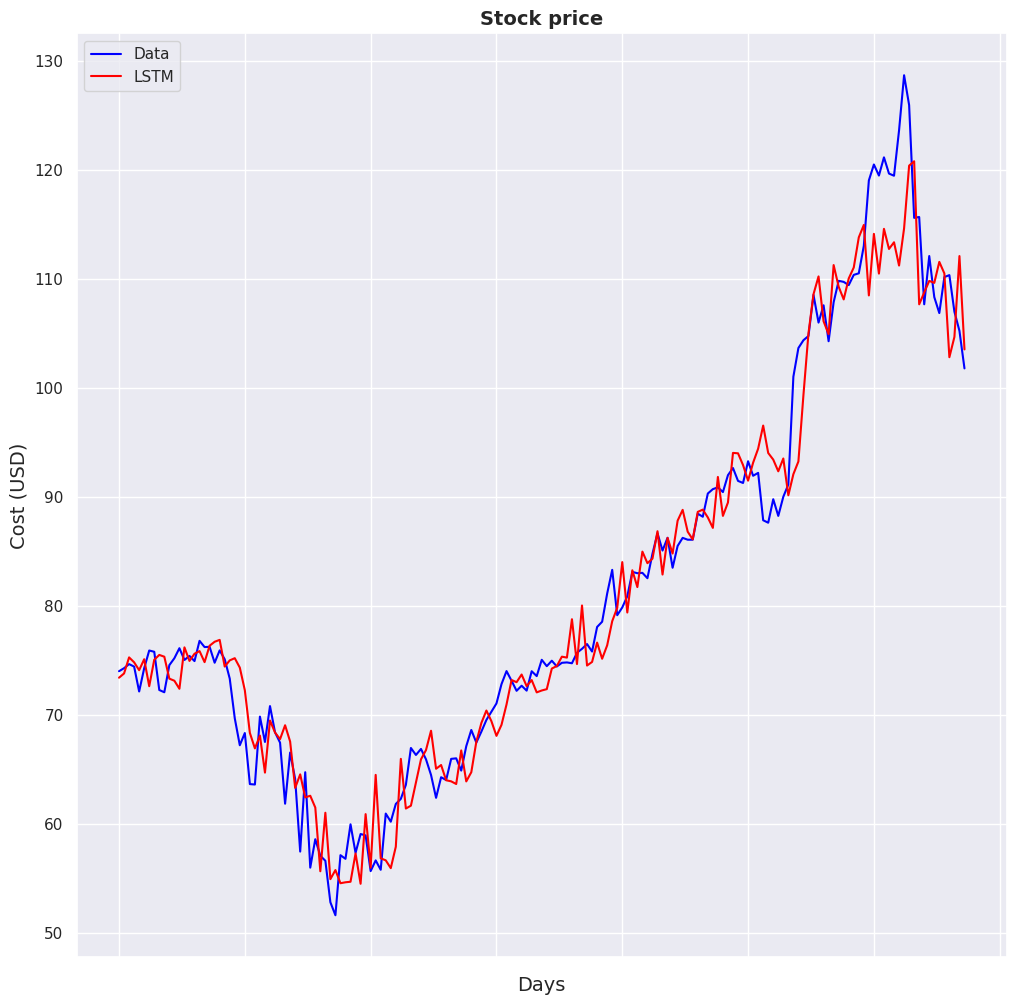

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.2, wspace=0.2)


ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='blue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="LSTM", color='red')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


#plt.subplot(1, 2, 2)
#ax = sns.lineplot(data=hist, color='royalblue')
#ax.set_xlabel("Epoch", size = 14)
#ax.set_ylabel("Loss", size = 14)
#ax.set_title("Training Loss", size = 14, fontweight='bold')
#fig.set_figheight(6)
#fig.set_figwidth(16)

In [ ]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scale.inverse_transform(y_train_pred.cpu().detach().numpy())
y_train = scale.inverse_transform(y_train.cpu().detach().numpy())
y_test_pred = scale.inverse_transform(y_test_pred.cpu().detach().numpy())
y_test = scale.inverse_transform(y_test.cpu().detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 3.73 RMSE
Test Score: 5.87 RMSE
